## Benefits and restrictions of stareg

test staregs capability for constraint regression on the following examples:

1. $f(x) = 2.1*\exp(-\frac{(x - 0.2)^2}{0.01})$
2. $f(x) = 2.3*x - 3*x^3$

Important points to consider are the following:

- Data distribution: bulk vs. well behaving
- Signal to noise ratio

In [29]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from stareg.star_model import StarModel
from stareg.utils import check_constraint_full_model
from plotly.subplots import make_subplots
np.random.seed(42)

In [98]:
samples = 200
x = np.random.random(samples).reshape((-1,1))
x.sort(axis=0)
noise = np.random.random(samples).reshape((-1,1))

#y_true = -2.1*np.exp(-(x - 0.2)**3 / 0.1) 
y_true = 2.1*np.exp(-(x - 0.2)**2 / 0.1) 
y = y_true + 0.2*noise

# Data Preprocessing
xmin, xmax = x.min(), x.max()
ymean, ystd = y.mean(), y.std()

#x_transformed = (x - xmin) / (xmax - xmin)
#y_transformed = (y - ymean) / ystd
x_transformed = x
y_transformed = y
# Train Test Split
df = pd.DataFrame(data={"x":x_transformed.ravel(), "y":y_transformed.ravel()})
df_train, df_test = train_test_split(df, test_size=0.33, random_state=42)
df_train, df_test = df_train.sort_index(), df_test.sort_index()
X_train, y_train = df_train["x"].values.reshape((-1,1)), df_train["y"].values
X_test, y_test = x_transformed[df_test.index], y_transformed[df_test.index]

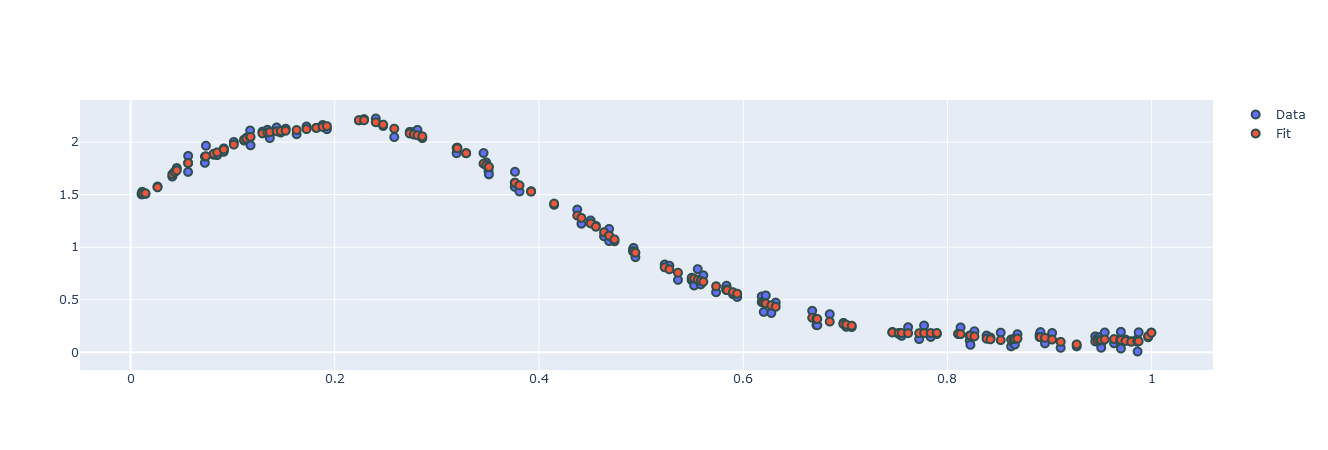

Violated Constraints: 18 from 30 
MSE =  0.002226288203545304


In [113]:
# Model creation
description = ( ("s(1)", "inc", 30, (0, 0), "equidistant"), )
M = StarModel(description=description)
M.fit(X=X_train, y=y_train)
print("MSE = ", M.mse)
#Mbest = M.calc_GCV(X=X_train, y=y_train, n_grid=5)

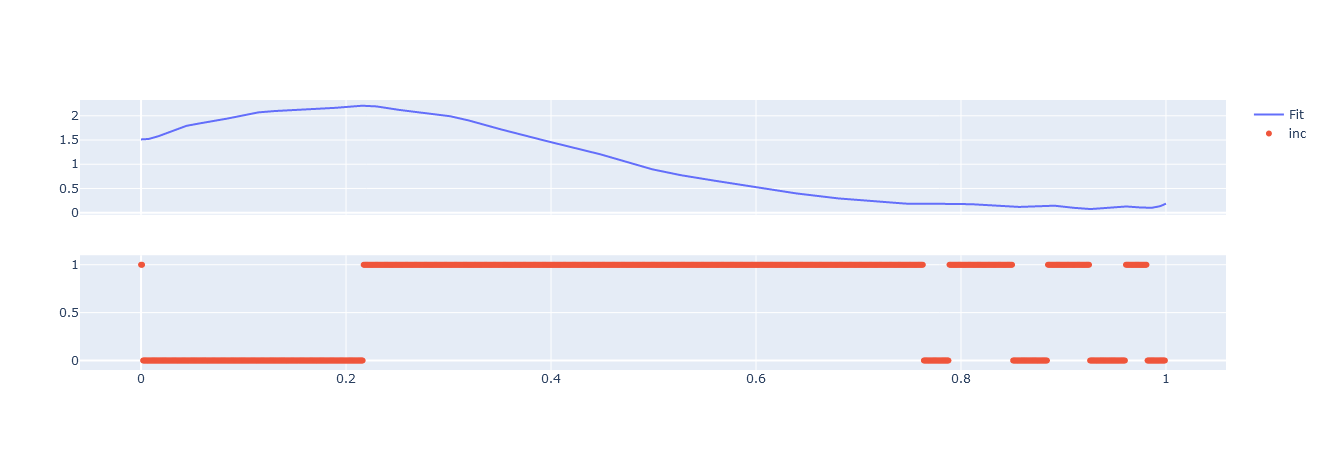

In [114]:
test = test_model_against_constraint(model=M, plot_=True)

In [101]:
check_constraint_full_model(M)

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 1])

In [10]:
from stareg.bspline import Bspline

BS = Bspline()

xx = np.linspace(0,1,1000)
BS.bspline_basis(x_data=xx, k=M.smooths[0].n_param)

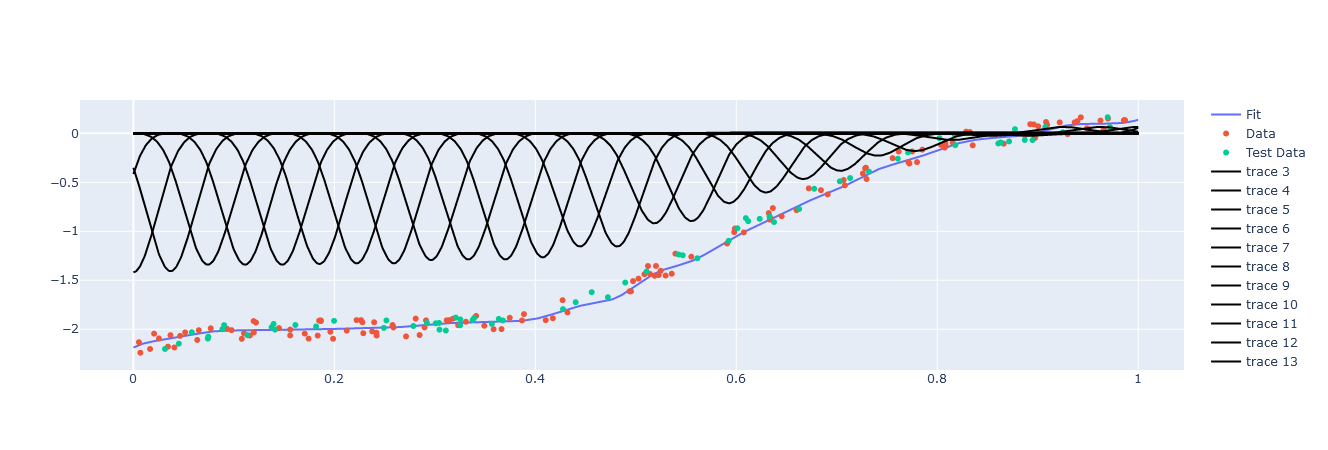

In [11]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=xx, y=BS.basis @ M.coef_, name="Fit"))
fig.add_trace(go.Scatter(x=X_train.ravel(), y=y_train.ravel(), name="Data", mode="markers"))
fig.add_trace(go.Scatter(x=X_test.ravel(), y=y_test.ravel(), name="Test Data", mode="markers"))
for i in range(BS.basis.shape[1]):
    #fig.add_trace(go.Scatter(x=xx, y=BS.basis[:,i]))
    fig.add_trace(go.Scatter(x=xx, y=BS.basis[:,i] * M.coef_[i], line=dict(color="black")))
fig.show()


In [80]:
from stareg.utils import check_peak_constraint, check_multi_peak_constraint
from stareg.utils import check_valley_constraint, check_multi_valley_constraint
from stareg.utils import check_peak_and_valley_constraint
from scipy.signal import find_peaks

In [108]:
def test_model_against_constraint(model, plot_=False):
    """Test the model against the constraint. 
    
    If the model fails the constraint, place a 1 at the point, else place a 0. 
    """
        
    x_test = np.linspace(0,1,1000)
    bs = Bspline()
    bs.bspline_basis(x_data=x_test, k=model.smooths[0].n_param)
    y_pred = bs.basis @ model.coef_
    constraint = model.smooths[0].constraint
    
    if constraint == "inc":
        test = np.diff(y_pred) < 0
    elif constraint == "dec":
        test = np.diff(y_pred) > 0
    elif constraint == "conv":
        test = np.diff(np.diff(y_pred)) < 0
    elif constraint == "conc":
        test = np.diff(np.diff(y_pred)) > 0
    elif constraint == "peak":
        test = check_peak_constraint(beta=y_pred)
    elif constraint == "multi-peak":
        test = check_multi_peak_constraint(beta=y_pred)
    elif constraint == "valley":
        test = check_valley_constraint(beta=y_pred)
    elif constraint == "multi-valley":
        test = check_multi_valley_constraint(beta=y_pred)
    elif constraint == "peak-and-valley":
        test = check_peak_and_valley_constraint(beta=y_pred)
    
    test = test.astype(np.int)
    
    if plot_:
        fig = make_subplots(rows=2, cols=1, shared_xaxes=True)        
        fig.add_trace(go.Scatter(x=xx, y=y_pred, name="Fit"), row=1, col=1)
        fig.add_trace(go.Scatter(x=xx, y=test, mode="markers", name=constraint), row=2, col=1)
        fig.show()
    return 
    

In [83]:
idx

110

In [12]:
x_test = np.linspace(0,1,1000)
bs = Bspline()
bs.bspline_basis(x_data=x_test, k=M.smooths[0].n_param)
y_pred = bs.basis @ M.coef_
constraint = M.smooths[0].constraint

In [20]:
test = np.diff(y_pred) < 0

In [62]:
M.smooths[0].constraint

'dec'

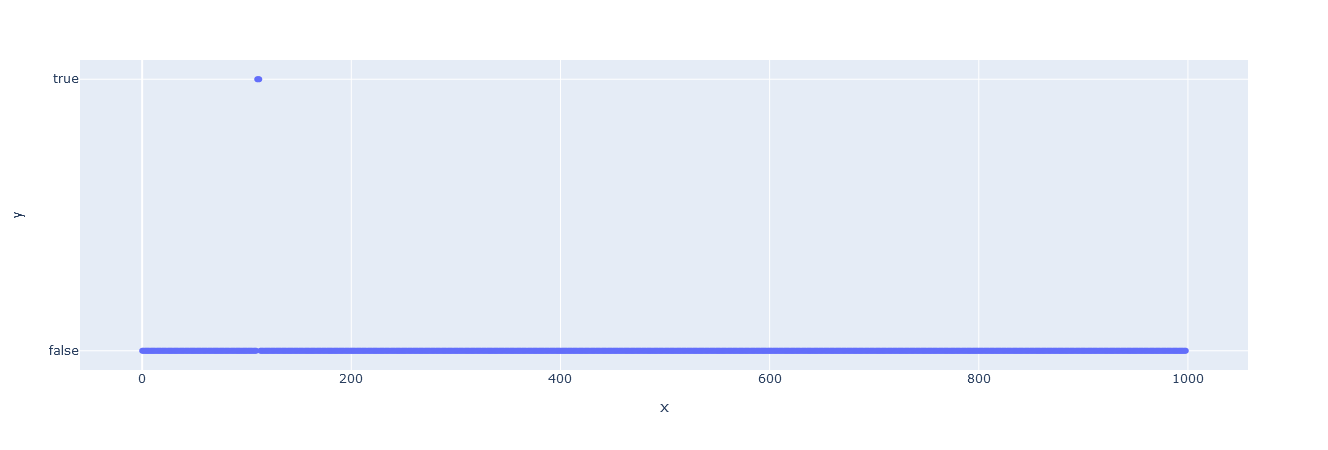

In [22]:
px.scatter(x=np.arange(len(test)), y=test)

In [92]:
find_peaks(y_pred, distance=len(y_pred))
y_pred[110]
xx[110]

0.11011011011011011

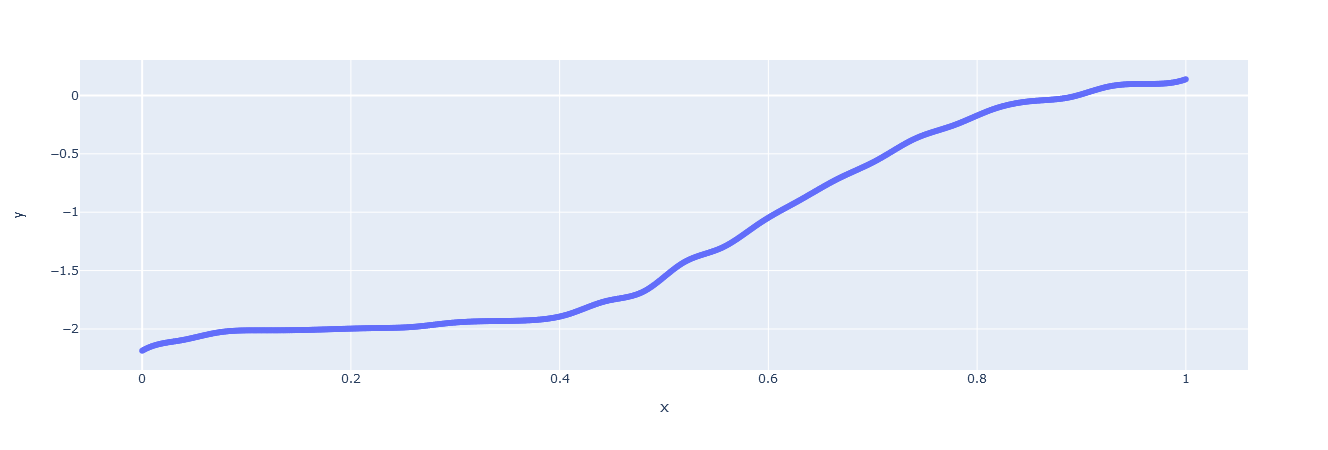

In [88]:
px.scatter(x=xx, y=y_pred)

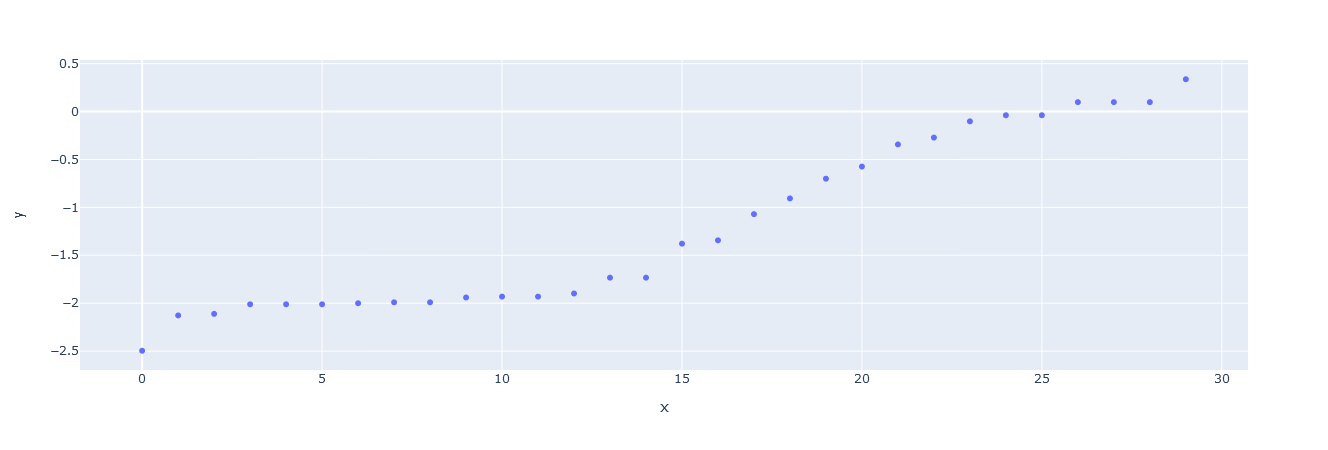

In [19]:
px.scatter(y=M.coef_)